### Business context and objectives

After reading the assignment and before looking up the data, we have to define what is the problem we are going to solve or the objective we have to aim for. Reading the assignment we know that:
- The **final objective is to make better investment decisions** in the self-storage business. This could be translated to: where is the best place where the company can build its next self-storage?. Given that the decision in the statement is not specified, our objective will answer the business question **where is the best place where the company Public Storage can build its next self-storage?**
- Important business features for self-storage are population income and employment.
- It's hoped that this analysis will find *new, interesting computed variables to use*.

Given that we are time-constrained, this approach will be used to answer the business question:
- As we only have data about the self-storage supply we need to get the demand from somewhere. One alternative is to create an estimated demand based on GDP per capita (as population income is one of the important business features as told in the assignment). For this we will use `population from 2020` by state from [census.gov](https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html#par_textimage), `total GDP 2021` and `pct change GDP from Q1 2021 to Q4 2022` from [bea.gov](https://www.bea.gov/data/gdp/gdp-state). The data was manually worked in an excel and passed manually to a pandas Dataframe called `df_st` where its non-self explainable columns are:
- `Pop`: Population.
- `GDP_21`: The full year 2021 GDP, in million USD.
- `pct_change`: Percent change in GDP from Q4 2021 to Q1 2022.

# Set-up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)

In [2]:
df_st = pd.DataFrame({
    'State_name': ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming'],
    'ST': ['AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY'],
    'Pop': [5024279,733391,7151502,3011524,39538223,5773714,3605944,989948,689545,21538187,10711908,1455271,1839106,12812508,6785528,3190369,2937880,4505836,4657757,1362359,6177224,7029917,10077331,5706494,2961279,6154913,1084225,1961504,3104614,1377529,9288994,2117522,20201249,10439388,779094,11799448,3959353,4237256,13002700,1097379,5118425,886667,6910840,29145505,3271616,643077,8631393,7705281,1793716,5893718,576851],
    'GDP_21': [257465,57983,429819,150483,3513348,440903,308671,84206,156457,1286086,713948,94937,98455,973486,438012,225696,198291,244480,267126,79177,451986,663750,592349,429391,129974,373105,61983,154149,204306,102439,700119,114680,1914207,684607,66372,765003,218564,279424,874881,68823,281754,62809,439050,2104579,230342,37644,614754,696748,91953,379909,44323],
    'pct_change': [-1.8,-8.2,-2.5,-0.9,-1,-1.9,-1.4,-1.4,-1.3,-1.3,-0.6,-3.5,-1.1,-2.5,-1.6,-1.3,-2.6,-2.6,-4.3,-1.3,-0.3,0.2,0.1,-2,-1.3,-1.9,-3.8,-2.4,-0.6,1.2,-2.2,-4.7,-1.3,-1.4,-6.3,-1.8,-3.7,-0.7,-2,-0.6,-1.1,-3.5,-1.2,-2.3,-2,0.7,-1.7,-3.3,-6.1,-0.2,-9.7]
})
display(df_st.shape)
df_st.head()

(51, 5)

,State_name,ST,Pop,GDP_21,pct_change
0,Alabama,AL,5024279,257465,-1.8
1,Alaska,AK,733391,57983,-8.2
2,Arizona,AZ,7151502,429819,-2.5
3,Arkansas,AR,3011524,150483,-0.9
4,California,CA,39538223,3513348,-1.0


In [3]:
df = pd.read_csv('input/property locations.csv')
display(df.shape)
df.head(3)

(4431, 8)

,Market,"Owner/Operator, Franchise",ADDRESS,CTY,ST,Zip,Area,Year
0,Albuquerque,Extra Space Storage,1522 Pacheco Street,Santa Fe,NM,87505,73934.0,2000.0
1,Albuquerque,Extra Space Storage,1909 Golf Course Road SE,Rio Rancho,NM,87124,72836.0,2000.0
2,Albuquerque,Extra Space Storage,3300 Calle Cuervo NW,Albuquerque,NM,87114,80889.0,1998.0


# Initial EDA & preprocessing

In [4]:
# drop duplicates
n_1 = df.shape[0]
df = df.drop_duplicates()
n = df.shape[0]
print(f'Initial df with {n_1} rows where {n_1 - n} rows are duplicated and deleted, leaving a final df with {n} rows.')

Initial df with 4431 rows where 49 rows are duplicated and deleted, leaving a final df with 4382 rows.


In [5]:
# Changuing column names for a better practical use
df = df.rename(columns={'Owner/Operator, Franchise':'OOF', 'ADDRESS': 'Addr', 'CTY': 'City'})

# Reset index for prevention
df = df.reset_index(drop=True)

In [6]:
df.dtypes

Market     object
OOF        object
Addr       object
City       object
ST         object
Zip         int64
Area      float64
Year      float64
dtype: object

In [7]:
df.isnull().sum()

Market     0
OOF        0
Addr       0
City       0
ST         0
Zip        0
Area       3
Year      73
dtype: int64

<AxesSubplot:>

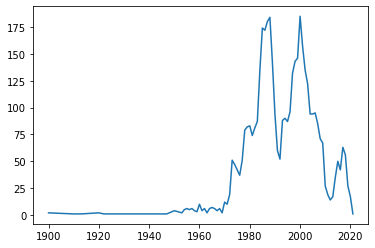

In [8]:
df.Year.value_counts().sort_index().plot()

### Insight list
1. We have some nulls in Area and Year features. We can see that the `Year` distribution concentrates mostly in the last 50 years. A self-storage useful life is 39 years (source: Inside Self Storage) [[1]](https://www.insideselfstorage.com/tax-issues/step-step-guide-self-storage-taxes-cost-segregation-and-cash-flow), so we can assume that self-storage area doesn't change significantly over time. Given this, we could sum up areas for different years given a certain group.

In [9]:
# Plot unique values and their quantity for each categorical column
for i in df.select_dtypes(include=['object', 'int64']).columns:
    print(f'Total unique {i} columns values:', df[i].nunique(), '\n' ,df[i].value_counts(), '\n')

Total unique Market columns values: 114 
 Houston - West        133
Atlanta - Suburban    127
Chicago - Suburban    122
Dallas - North        111
Northern Virginia     104
                     ... 
Tulsa                   2
El Paso                 1
Tallahassee             1
South Bend              1
Syracuse                1
Name: Market, Length: 114, dtype: int64 

Total unique OOF columns values: 17 
 Public Storage                     2442
Extra Space Storage                1099
CubeSmart Self Storage              599
StorageMart                         111
Public Storage Phase II              51
EZ Storage                           45
Storage Mart                         11
Extra Space Storage Phase II          8
Public Storage Phase ll               3
Cubesmart Self Storage                3
Ez Storage                            2
StorageMart Phase II                  2
EZ Storage Phase II                   2
CubeSmart Self Storage Phase II       1
Extra Space Storage Phase ll    

### Insight list
2. We have a total of 4311 unique `Addr` values, 2552 unique `Zip` values, and 4382 rows of non-duplicated data. This means that `Zip` values don't represent the exact location and imply that we have different `Addr` for the same `Zip` value. Further, as the number of non-duplicated rows is higher than the unique `Addr` values, this implies we have the same `Addr` value for different rows, the question is why? If each row represents an Area, Year, Location (Addr), and OOF, why we would have the same location for two self-storage projects? We will explore this point in a while.
3. The total OOF unique values are 17. However, we can see that there are various string problems: There are Phase I, II, and III for the same OOF, which means (I guess) the project is so big that was needed to separate it in Phases. We will join those OOF values, and also we will correct some strings differences (e.g. `EZ Storage == Ez Storage`, `StorageMart == Storage Mart`, etc.). Lastly, we will replace `l` by `I`, `ll` by `II`, `lll` by `III` as it seems an error of input values.
4. It's worth mentioning that the US has 51 states (including DC) and this dataset only has 41 states.

**Now we will try to identify the primary key columns, explore Insight 2, and some Missing Values**. 

Why we will try to identify primary key columns? Because it's essential as it tells us exactly what means each row. If we have a clear understanding of what means each row, we will have a significantly clearer perspective on how to use the data.

In [10]:
# Attempt to identify primary key columns
display(df.shape)
def identify_primary_cols(df):
    data = df.groupby(['Market', 'OOF', 'Addr', 'City', 'ST'], as_index=False).count().sort_values(['Zip', 'Area', 'Year'], ascending=[False, False, False])
    display(data)
    mask = (data['Zip'] > 1) | (data['Area'] > 1) | (data['Year'] > 1)
    
    idx = data[mask].index
    mask = df.index.isin(idx)

    return(df[mask])

identify_primary_cols(df)

(4382, 8)

,Market,OOF,Addr,City,ST,Zip,Area,Year
487,Bay Area - South Bay,Public Storage,20565 Valley Green Drive,Cupertino,CA,2,2,1
1963,Indianapolis,Extra Space Storage,501 Fulton Street,Indianapolis,IN,2,2,1
2347,Los Angeles - Eastern County,Public Storage,3625 South Grand Avenue,Los Angeles,CA,2,2,1
0,Albuquerque,CubeSmart Self Storage,11801 Montgomery Blvd,Albuquerque,NM,1,1,1
1,Albuquerque,CubeSmart Self Storage,2001 Girard Blvd SE,Albuquerque,NM,1,1,1
...,...,...,...,...,...,...,...,...
4309,West Palm Beach - Boca Raton,Public Storage Phase II,7480 South Military Trail,Lake Worth,FL,1,1,0
4310,West Palm Beach - Boca Raton,Public Storage Phase II,975 Military Trail,Jupiter,FL,1,1,0
302,Baltimore,EZ Storage Phase II,1450 Taylor Avenue,Parkville,MD,1,0,0
2684,New Jersey - Northern,CubeSmart Self Storage,110 Pleasant Avenue,Upper Saddle River,NJ,1,0,0


,Market,OOF,Addr,City,ST,Zip,Area,Year
487,Indianapolis,Extra Space Storage,5335 East 65th Street,Indianapolis,IN,46220,41110.0,2000.0
1963,Atlanta - Urban,Public Storage,1210 Clairmont Road,Decatur,GA,30030,75207.0,1992.0
2347,Chicago - Suburban,Public Storage,3120 Vimy Ridge Drive,Joliet,IL,60435,97863.0,2001.0


We have some rows with same the `Zip` and `Area`. So we will see duplicates of our string columns, `Zip`, and `Addr`.

In [11]:
mask = df[['Market', 'OOF', 'Addr', 'City', 'ST']].duplicated(keep=False)
df[mask]

,Market,OOF,Addr,City,ST,Zip,Area,Year
479,Indianapolis,Extra Space Storage,501 Fulton Street,Indianapolis,IN,46202,115000.0,NaN
492,Indianapolis,Extra Space Storage,501 Fulton Street,Indianapolis,IN,46202,67690.0,1990.0
2119,Bay Area - South Bay,Public Storage,20565 Valley Green Drive,Cupertino,CA,95014,263671.0,NaN
2160,Bay Area - South Bay,Public Storage,20565 Valley Green Drive,Cupertino,CA,95014,68122.0,1976.0
3115,Los Angeles - Eastern County,Public Storage,3625 South Grand Avenue,Los Angeles,CA,90007,229741.0,NaN
3145,Los Angeles - Eastern County,Public Storage,3625 South Grand Avenue,Los Angeles,CA,90007,96335.0,2012.0


In [12]:
df[df['Zip'].duplicated(keep=False)].sort_values('Zip')

,Market,OOF,Addr,City,ST,Zip,Area,Year
1106,Worcester - Springfield,Extra Space Storage,245 Washington Street,Auburn,MA,1501,58800.0,1999.0
1704,Worcester - Springfield,CubeSmart Self Storage,198 Washington Street,Auburn,MA,1501,100685.0,1957.0
1102,Worcester - Springfield,Extra Space Storage,53 Clinton Street,Shrewsbury,MA,1545,68400.0,1982.0
1707,Worcester - Springfield,CubeSmart Self Storage,757 Boston Turnpike,Shrewsbury,MA,1545,59060.0,2015.0
168,Boston,Extra Space Storage,15 Olympia Avenue,Woburn,MA,1801,56773.0,1974.0
...,...,...,...,...,...,...,...,...
4141,Tacoma,Public Storage,8033 Martin Way East,Lacey,WA,98516,72120.0,1989.0
877,Portland,Extra Space Storage,8016 NE 78th Street,Vancouver,WA,98662,65875.0,1988.0
3712,Portland,Public Storage,9421 NE Fourth Plain Blvd,Vancouver,WA,98662,49227.0,1982.0
3711,Portland,Public Storage,1401 NE 134th Street,Vancouver,WA,98685,68938.0,1997.0


This demonstrates the statements we made in our Insight 2: `Zip` values don't represent the exact location and imply that we have different `Addr` for the same `Zip` value.

In [13]:
df[df['Addr'].duplicated(keep=False)].sort_values('Addr')

,Market,OOF,Addr,City,ST,Zip,Area,Year
2973,Houston - West,Public Storage Phase II,1001 South Mason Road,Katy,TX,77450,21025.0,NaN
2902,Houston - West,Public Storage,1001 South Mason Road,Katy,TX,77450,77865.0,2000.0
4202,Tampa - St Petersburg - Clearwater,Public Storage Phase ll,1007 East Brandon Blvd,Brandon,FL,33511,133939.0,NaN
4177,Tampa - St Petersburg - Clearwater,Public Storage,1007 East Brandon Blvd,Brandon,FL,33511,91130.0,1997.0
2162,Bay Area - South Bay,Public Storage Phase II,1060 Stewart Drive,Sunnyvale,CA,94085,317392.0,NaN
...,...,...,...,...,...,...,...,...
4221,Twin Cities - Suburban,Public Storage,8124 Lakeland Avenue North,Brooklyn Park,MN,55445,72786.0,1979.0
2735,Fort Lauderdale,Public Storage,850 South Dixie Hwy,Pompano Beach,FL,33060,63585.0,1976.0
2782,Fort Lauderdale,Public Storage Phase II,850 South Dixie Hwy,Pompano Beach,FL,33060,97236.0,NaN
4307,West Palm Beach - Boca Raton,Public Storage,975 Military Trail,Jupiter,FL,33458,103915.0,1986.0


Here we can see some explanation for Insight 2 (Insight 2: why are there the same `Addr` value for different rows?): They have different areas with one `Year` value missing. This could be because the self-storage project was expanded or maybe was created other in the same location (Phase II). Whatever the case, the useful life of self-storage is significantly long so we can ignore `Year` and aggregate those areas in one project.

In [14]:
# Let's see the rows with any missing value
mask = (~df.isnull()).prod(axis=1).astype(bool)
df[~mask].sort_values('OOF')

,Market,OOF,Addr,City,ST,Zip,Area,Year
1541,Philadelphia - Suburban,CubeSmart Self Storage,400 Guthrie Road,Wayne,PA,19087,98650.0,NaN
1514,Northern Virginia,CubeSmart Self Storage,223 NE Mill Street,Vienna,VA,22180,125000.0,NaN
1304,Cleveland - Akron,CubeSmart Self Storage,2000 Brookpark Road,Cleveland,OH,44109,80000.0,NaN
1506,New Jersey - Northern,CubeSmart Self Storage,110 Pleasant Avenue,Upper Saddle River,NJ,7458,NaN,NaN
1457,Las Vegas,CubeSmart Self Storage Phase II,7370 West Cheyenne Avenue,Las Vegas,NV,89129,28450.0,NaN
1759,Washington DC - Suburban Maryland,EZ Storage Phase II,800 Ritchie Road,Capitol Heights,MD,20743,50000.0,NaN
1734,Baltimore,EZ Storage Phase II,1450 Taylor Avenue,Parkville,MD,21234,NaN,NaN
479,Indianapolis,Extra Space Storage,501 Fulton Street,Indianapolis,IN,46202,115000.0,NaN
986,San Fernando Valley - Ventura County,Extra Space Storage,4753 East Los Angeles Avenue,Simi Valley,CA,93063,114444.0,NaN
148,Bay Area - South Bay,Extra Space Storage Phase II,2576 Scott Blvd,Santa Clara,CA,95050,52508.0,NaN


As the missing values are concentrated in the Year column and we don't see any pattern, we will ignore the Year column when aggregating as the useful life of public storage is significantly long.

In [15]:
# We will check if Market column is implied by Addr column
display(df['Addr'].drop_duplicates().shape)
df[['Market', 'Addr']].drop_duplicates().shape

(4311,)

(4311, 2)

Given that:
- There is no clear a primary key column
- There is multiple OOF that represent the same OOF (Insight 3)
- `Addr` is too specific

We can group the dataset by `OOF` and `ST` aggregating the `Area`. But before we need to implement Insight 3

In [16]:
# Implementing insight 3
strings_to_remove = ['Phase III', 'Phase II', 'Phase I', 'Phase lll', 'Phase ll', 'Phase l',
                     ' III',' II',' I',' lll',' ll',' l']
for i in strings_to_remove:
    df['OOF'] = df['OOF'].str.replace(i,'').str.strip()
df['OOF'] = df['OOF'].str.lower().str.capitalize()
df['OOF'] = df['OOF'].replace({'Storage mart':'Storagemart'})

In [17]:
print(f'Total unique OOF columns values:', df['OOF'].nunique(), '\n' ,df['OOF'].value_counts(), '\n')

Total unique OOF columns values: 6 
 Public storage            2497
Extra space storage       1108
Cubesmart self storage     603
Storagemart                124
Ez storage                  49
Ps business parks            1
Name: OOF, dtype: int64 



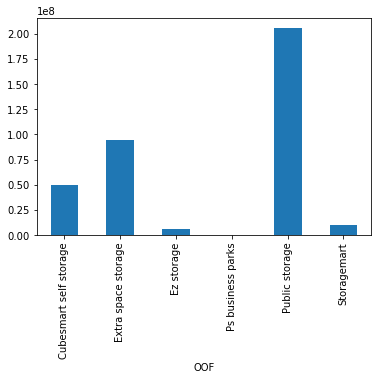

In [18]:
df.groupby('OOF')['Area'].sum().plot(kind='bar')
plt.show()

### Insight list

6. According to the plot above, Public Storage has at least the double of self-storage area as any other company.

The next table will serve as input for the methodology we are going to use to answer the business decision. What we do here is:
1. We group the data by `State` and `OOF`, summing up the Area.
2. Compute the GDP per capita in thousands US dollars.
3. Compute the Total State Self Storage (SS) area per person. The higher this number is, the more SS area per person is in the State. The more SS is per person are in the State less likely building a Self Storage profitable in that State will be.
4. We scale (from 0 to 1) the feature created at (3). This is a preprocessing step for step 6.
5. To 1 we subtract the feature (4). This feature is called `Total SS Area per person inv_scaled`. This is a preprocessing step for step 6.
6. We multiply the feature we created at step 5 with the GDP per capita, creating the feature called `Potential`. As the first feature tells us the higher the number less SS area per person in the State, being scaled from 0 to 1 would allow us to have comparable numbers when multiplying it with GDP per capita. This multiplication tells us how much GDP per capita has a State considering the SS area in that State. And how it considers the SS area? It considers it penalizing the GDP per capita given a SS area in that State (it receives a higher penalization given a higher SS area in that State)
7. We sort the dataframe by the State given the maximum Potential for each State, and within each State we sort it by Potential too.

In [19]:
def minmaxscaler(series):
    scaled_series = (series - series.min()) / (series.max() - series.min())
    return(scaled_series)

# Step 1, 2 and 3
data = pd.merge(df.groupby(['ST','OOF'], as_index=False).Area.sum(),
                df_st,
                on='ST',
                how='left')
data = data.drop('State_name', axis=1)
data['GDP_per_cap_K'] = round(data['GDP_21'].div(data['Pop'])*1000000,1)
data['Total SS Area'] = data.groupby('ST')['Area'].transform('sum')
data['Total SS Area per person'] =  data['Total SS Area'] / data.Pop

# Step 4 and 5
data['Total SS Area per person inv_scaled'] = 1- minmaxscaler(data['Total SS Area per person'])

# Step 6
data['Potential'] = data['Total SS Area per person inv_scaled'] * data['GDP_per_cap_K']

# Step 7
data = data.sort_values('Potential', ascending=False)
data = pd.merge(data, 
         data['ST'].drop_duplicates().reset_index(drop=True).reset_index(),
         on='ST',
         how='left').sort_values(['index', 'Potential'], ascending=[True, True])
display(data.head(100))
data.tail(20)

,ST,OOF,Area,Pop,GDP_21,pct_change,GDP_per_cap_K,Total SS Area,Total SS Area per person,Total SS Area per person inv_scaled,Potential,index
0,DC,Public storage,190200.0,689545,156457,-1.3,226898.9,1023945.0,1.484957,0.395626,89767.092374,0
1,DC,Extra space storage,278653.0,689545,156457,-1.3,226898.9,1023945.0,1.484957,0.395626,89767.092374,0
2,DC,Cubesmart self storage,555092.0,689545,156457,-1.3,226898.9,1023945.0,1.484957,0.395626,89767.092374,0
3,DE,Public storage,278987.0,989948,84206,-1.4,85061.0,355387.0,0.358996,0.877566,74646.666983,1
4,DE,Extra space storage,76400.0,989948,84206,-1.4,85061.0,355387.0,0.358996,0.877566,74646.666983,1
5,NH,Extra space storage,157890.0,1377529,102439,1.2,74364.3,319138.0,0.231674,0.932063,69312.219233,2
6,NH,Public storage,161248.0,1377529,102439,1.2,74364.3,319138.0,0.231674,0.932063,69312.219233,2
7,NY,Public storage,6488462.0,20201249,1914207,-1.3,94756.9,15005109.0,0.742781,0.713296,67589.743821,3
8,NY,Extra space storage,3862083.0,20201249,1914207,-1.3,94756.9,15005109.0,0.742781,0.713296,67589.743821,3
9,NY,Cubesmart self storage,4480040.0,20201249,1914207,-1.3,94756.9,15005109.0,0.742781,0.713296,67589.743821,3


,ST,OOF,Area,Pop,GDP_21,pct_change,GDP_per_cap_K,Total SS Area,Total SS Area per person,Total SS Area per person inv_scaled,Potential,index
100,GA,Cubesmart self storage,2211374.0,10711908,713948,-0.6,66649.9,16424786.0,1.533320,0.374925,24988.742087,36
101,TX,Cubesmart self storage,8998506.0,29145505,2104579,-2.3,72209.4,47383938.0,1.625772,0.335354,24215.701005,37
102,TX,Storagemart,461031.0,29145505,2104579,-2.3,72209.4,47383938.0,1.625772,0.335354,24215.701005,37
103,TX,Public storage,28262236.0,29145505,2104579,-2.3,72209.4,47383938.0,1.625772,0.335354,24215.701005,37
104,TX,Extra space storage,9662165.0,29145505,2104579,-2.3,72209.4,47383938.0,1.625772,0.335354,24215.701005,37
105,VA,Cubesmart self storage,1238638.0,8631393,614754,-1.7,71223.0,15277941.0,1.770043,0.273602,19486.745977,38
106,VA,Extra space storage,4541643.0,8631393,614754,-1.7,71223.0,15277941.0,1.770043,0.273602,19486.745977,38
107,VA,Ez storage,1211976.0,8631393,614754,-1.7,71223.0,15277941.0,1.770043,0.273602,19486.745977,38
108,VA,Ps business parks,27975.0,8631393,614754,-1.7,71223.0,15277941.0,1.770043,0.273602,19486.745977,38
109,VA,Public storage,7930745.0,8631393,614754,-1.7,71223.0,15277941.0,1.770043,0.273602,19486.745977,38


To give an example from the table above, we can see that the State DC has the biggest Potential for a new Self Storage building, even when DC has a pretty high `Total SS Area per person` of `1.48`, this is because of its extremely high GDP per capita.

### Answering the business question

To answer the business question **where is the best place where the company Public Storage can build its next self-storage?**

1. First, we need to choose a State. Assuming the average propensity (of each State) to rent a SS unit area is the same across the States, we can say that the less SS Area per person has a State, the higher the value of the new unit SS area in that State will be as it's more scarce compared with another state with higher SS area per person.
2. However, in order to purchase something you wish, first, you need to be able to afford it. A higher GDP per person can be interpreted as a higher probability to afford something (as GDP per person measures total output per person).

Multiplying those two metrics, we create the `Potential` feature.

As the State with the highest `Potential` value and without a SS from Public Storage is Iowa (IA), the best place where the company Public Storage can build its next self-storage is the State of Iowa (IA).

- In addition, the Financial figures and assumptions provided in the assignment weren't used as they don't impact the decision criteria because they are the same for every project and State.

# Discussion and final comments

### Points of discussion

1. We could apply the same methodology for `Market`, `City` or `Zip` if we get the data. Or we could develop a ML model if we can get georeferential data about the daily flow of citizens in each state in order to see which location with a high flow of people doesn't have any Self Storage in order to build one or maybe if it's worth to compete if there is already a Self Storage from the competition on site.

[This study](https://theparhamgroup.com/learn-self-storage/blog/feasibility-studies-and-site-selection/) from The Parham Group, below the subtitle "*WHO ARE OUR CUSTOMERS*" (it's a bit old, but it's the best we have) states that the typical Self Storage tenant are:
- Women comprise up to 84% of self storage patrons
- 95% of the actual move-ins are performed by men
- 88% are between the age of 21 and 55 years of age.
- 78% have incomes between lower middle and upper middle income
- 75% of tenants live or work within 2 miles of the property
- 85% of tenants come from “Drive By Traffic.”

2. Given the study above, getting socioeconomic data by County would be a good feature to have in the future given that we could aim at those Counties with high socioeconomic levels and low Total Self Storage Area. This approach would help to identify clients in a new location that behave similarly to those in the study above (To identify clients with a different profile we would have to try a different approach)


### Final comments

- **Assessing my ML skills**: I know this assessment aimed to evaluate my ML skills (among other things), but as I didn't find necessary to develop a ML model to solve the business question I didn't develop one as in a real project I wouldn't recommend developing a ML model if a simpler solution is on reach. However, in order to help you to assess me, you can see a more technical ML project [here](https://github.com/cyapur/time-series-modeling/blob/main/a-time-series-business-application-case.ipynb) to assess my ML skills and coding practices.